# Data Import and Cleaning 

#### Datasets from here: 
- https://www.census.gov/programs-surveys/sipp/data/datasets/2008-panel/wave-1.html
- https://www.census.gov/programs-surveys/sipp/data/datasets/2008-panel/wave-2.html
#### Column definition from here: 
- https://www2.census.gov/programs-surveys/sipp/data/datasets/2008/l08puw1.sas
- https://www2.census.gov/programs-surveys/sipp/data/datasets/2008/p08putm1.sas

In [2]:
import numpy as np
import pandas as pd

In [1]:
# sas input statement needs to be cleaned by hand: remove all whitespaces and $-signs e.g. replace ' -' with '-'
# columns that should be kept, need to be defined by hand as well
def import_sipp_data(sas_input_statement, dat_file, columns_keep):
    input_dict = np.loadtxt(sas_input_statement, dtype = str)
    column_lst = input_dict[:, 0].tolist()
    
    colspecs = []
    for string in input_dict[:, 1]:
        tpl_temp = tuple(map(int, string.split('-')))
        tpl_temp = (tpl_temp[0]-1, tpl_temp[1]) # second number should also be corrected?
        colspecs.append(tpl_temp)
    df_raw = pd.read_fwf(dat_file, names=column_lst, colspecs=colspecs)

    df = df_raw[columns_keep]
    del df_raw
    return df

In [3]:
# columns core dataset
clmn_join = ['SSUID', 'SPANEL', 'SWAVE', 'TFIPSST', 'EOUTCOME', 'SHHADID', 'RFID', 'RFID2', 'EENTAID','EPPPNUM', 'EPOPSTAT', 'EPPINTVW', 'ESEX', 
            'ERACE', 'EORIGIN', 'WPFINWGT', 'ERRP', 'EMS', 'EPNMOM', 'EPNDAD', 'EPNGUARD', 'EPNSPOUS', 'RDESGPNT', 'TAGE', 'EEDUCATE']

clmn_general = ['SREFMON', 'EHREFPER', 'RHCALMN', 'RHCALYR', 'TMOVRFLG', 'EHHNUMPP', 'EFSPOUSE', 'RFNKIDS', 'EBORNUS', 'ECITIZEN', 'RENROLL']

# make hist for all income categories and combine the small ones into a new 'other' or substract all interesting income streams from total and take the residual.
clmn_income = ['TFEARN', 'TFTOTINC', 'TPEARN', 'TPTOTINC', 'THTRNINC', 'THOTHINC', 'ETENURE', 'THPNDIST', 'THSOCSEC', 'THVETS', 'THLUMPSM', 'THAFDC', 
                'EAST1C', 'THPRPINC', 'TINTINC', 'TDIVINC', 'EAST3B', 'EAST3C', 'EAST3D', 'EAST3E', 'EAST4A' ]
# moonlit
clmn_labor = ['EPAYHR1', 'EPAYHR2', 'TPYRATE1', 'TPYRATE2', 'EJBHRS1', 'EJBHRS2', 'EUNION1', 'EUNION2', 'TMLMSUM', 'EDISABL', 'EDISPREV', 
                'EAWOP', 'EABRE', 'ERSNOWRK', 'EPTRESN', 'EBUSCNTR', 'EJOBCNTR', 'RMWKSAB', 'EPDJBTHN', 'ELKWRK', 'ELAYOFF', 'EHRSALL', 'EMOONLIT', 'RMHRSWK', 'EPTWRK', 
                'RMESR', 'RMWKWJB', 'RWKSPERM', 'EBNO1', 'EBNO2']

columns_core = clmn_join + clmn_general + clmn_income + clmn_labor
print('length core columns: ', len(columns_core))

# columns topical dataset
clmn_join

clmn_rebate = ['EREBATE', 'ERBAMTH', 'ERBATAMT', 'ERBATTYP', 'EREBATOC']

columns_topical = clmn_join + clmn_rebate
print('length topical columns: ', len(columns_topical))

length core columns:  87
length topical columns:  30


### Import SIPP data

In [5]:
w2_core = import_sipp_data('input_core.txt', '/Users/maxweber/Desktop/DataMasterThesis/l08puw2.dat', columns_core)
print('w2 core imported')
w2_core.to_csv('/Users/maxweber/Desktop/DataMasterThesis/core_w2.csv') 
print('w2 core exported to csv')

w1_core = import_sipp_data('input_core.txt', '/Users/maxweber/Desktop/DataMasterThesis/l08puw1.dat', columns_core)
print('w1 core imported')
w1_core.to_csv('/Users/maxweber/Desktop/DataMasterThesis/core_w1.csv') 
print('w1 core exported to csv')

[(0, 5), (5, 17), (17, 21), (21, 23), (23, 24), (24, 25), (25, 27), (27, 31), (31, 34), (34, 37), (37, 38), (38, 41), (41, 43), (43, 45), (45, 48), (48, 50), (50, 52), (52, 54), (54, 58), (58, 61), (61, 62), (62, 72), (72, 73), (73, 74), (74, 76), (76, 77), (77, 78), (78, 80), (80, 81), (81, 83), (83, 84), (84, 90), (90, 91), (91, 93), (93, 94), (94, 96), (96, 97), (97, 99), (99, 100), (100, 102), (102, 104), (104, 106), (106, 107), (107, 112), (112, 113), (113, 115), (115, 116), (116, 118), (118, 120), (120, 121), (121, 123), (123, 124), (124, 126), (126, 127), (127, 129), (129, 131), (131, 132), (132, 134), (134, 135), (135, 136), (136, 143), (143, 151), (151, 158), (158, 165), (165, 173), (173, 175), (175, 177), (177, 179), (179, 184), (184, 191), (191, 199), (199, 205), (205, 211), (211, 217), (217, 223), (223, 229), (229, 235), (235, 241), (241, 244), (244, 247), (247, 249), (249, 253), (253, 257), (257, 259), (259, 260), (260, 262), (262, 264), (264, 266), (266, 268), (268, 270),

In [4]:
w1_topical = import_sipp_data('input_topical_w1.txt', '/Users/maxweber/Desktop/DataMasterThesis/p08putm1.dat', columns_topical)
print('w1 topical imported')
w1_topical.to_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w1.csv') 
print('w1 topical exported to csv')

w2_topical = import_sipp_data('input_topical_w2.txt', '/Users/maxweber/Desktop/DataMasterThesis/p08putm2.dat', columns_topical)
print('w2 topical imported')
w2_topical.to_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w2.csv') 
print('w2 topical exported to csv')

[(0, 5), (5, 17), (17, 21), (21, 23), (23, 24), (24, 26), (26, 29), (29, 32), (32, 35), (35, 38), (38, 41), (41, 44), (44, 48), (48, 49), (49, 51), (51, 52), (52, 53), (53, 54), (54, 56), (56, 66), (66, 68), (68, 70), (70, 71), (71, 75), (75, 79), (79, 83), (83, 87), (87, 89), (89, 91), (91, 99), (99, 102), (102, 104), (104, 106), (106, 107), (107, 109), (109, 110), (110, 112), (112, 113), (113, 115), (115, 116), (116, 120), (120, 121), (121, 125), (125, 126), (126, 128), (128, 129), (129, 131), (131, 132), (132, 134), (134, 135), (135, 137), (137, 138), (138, 142), (142, 143), (143, 147), (147, 148), (148, 150), (150, 151), (151, 153), (153, 154), (154, 156), (156, 157), (157, 161), (161, 162), (162, 166), (166, 167), (167, 169), (169, 170), (170, 172), (172, 174), (174, 175), (175, 179), (179, 180), (180, 184), (184, 185), (185, 189), (189, 190), (190, 194), (194, 195), (195, 199), (199, 200), (200, 202), (202, 204), (204, 206), (206, 208), (208, 210), (210, 212), (212, 214), (214, 2

In [6]:
print(w1_core.shape)
print(w1_topical.shape)
w1_full = w1_core.merge(w1_topical, how = 'left', on = clmn_join)
w1_full.shape

(421911, 87)
(105663, 30)


(421911, 92)

In [7]:
print(w2_core.shape)
print(w2_topical.shape)
w2_full = w2_core.merge(w2_topical, how = 'left', on = clmn_join)
w2_full.shape

(392702, 87)
(98504, 30)


(392702, 92)

In [8]:
df = pd.concat([w1_full, w2_full])
df.to_csv('/Users/maxweber/Desktop/DataMasterThesis/full_sipp.csv') 
print(df.shape)
del [w1_core, w2_core, w1_topical, w2_topical]

df.head()

(814613, 92)


,SSUID,SPANEL,SWAVE,TFIPSST,EOUTCOME,SHHADID,RFID,RFID2,EENTAID,EPPPNUM,...,RMESR,RMWKWJB,RWKSPERM,EBNO1,EBNO2,EREBATE,ERBAMTH,ERBATAMT,ERBATTYP,EREBATOC
0,19128000276,2008,1,12,201,11,1,1,11,101,...,8,0,4,-1,-1,NaN,NaN,NaN,NaN,NaN
1,19128000276,2008,1,12,201,11,2,2,11,101,...,8,0,5,-1,-1,NaN,NaN,NaN,NaN,NaN
2,19128000276,2008,1,12,201,11,3,3,11,101,...,8,0,4,-1,-1,NaN,NaN,NaN,NaN,NaN
3,19128000276,2008,1,12,201,11,4,4,11,101,...,7,0,4,-1,-1,2.0,-1.0,0.0,-1.0,-1.0
4,19128000276,2008,1,12,201,11,1,1,11,102,...,8,0,4,-1,-1,NaN,NaN,NaN,NaN,NaN


In [9]:
df = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/full_sipp.csv')

df.shape

(814613, 93)

# ToDo: 

- compare to houshold dataframe and individual dataframe
- implement the cleaning steps from the other notebook

In [12]:
df[clmn_join].describe()

,SSUID,SPANEL,SWAVE,TFIPSST,EOUTCOME,SHHADID,RFID,RFID2,EENTAID,EPPPNUM,...,WPFINWGT,ERRP,EMS,EPNMOM,EPNDAD,EPNGUARD,EPNSPOUS,RDESGPNT,TAGE,EEDUCATE
count,8.146130e+05,814613.0,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,...,8.146130e+05,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000
mean,5.542630e+11,2008.0,1.482072,28.642511,201.737015,11.118716,2.876340,2.708309,11.020911,103.011426,...,2.944598e+07,3.190533,3.598717,6850.621604,7627.745526,72.752706,5971.135542,1.093927,37.006575,31.661892
std,2.639417e+11,0.0,0.499679,16.198959,5.178684,1.085508,1.770319,1.818694,0.458779,9.126882,...,1.157673e+07,2.261120,2.313829,4609.476314,4224.374923,669.907758,4862.158467,1.163861,22.672684,17.073818
min,1.912800e+10,2008.0,1.000000,1.000000,201.000000,11.000000,1.000000,-1.000000,11.000000,101.000000,...,0.000000e+00,1.000000,1.000000,101.000000,101.000000,-1.000000,101.000000,-1.000000,0.000000,-1.000000
25%,3.859251e+11,2008.0,1.000000,13.000000,201.000000,11.000000,2.000000,1.000000,11.000000,101.000000,...,2.062580e+07,1.000000,1.000000,102.000000,9999.000000,-1.000000,102.000000,1.000000,17.000000,34.000000
50%,5.669251e+11,2008.0,1.000000,29.000000,201.000000,11.000000,3.000000,3.000000,11.000000,102.000000,...,2.831825e+07,3.000000,4.000000,9999.000000,9999.000000,-1.000000,9999.000000,2.000000,37.000000,39.000000
75%,7.399255e+11,2008.0,2.000000,42.000000,201.000000,11.000000,4.000000,4.000000,11.000000,103.000000,...,3.646230e+07,4.000000,6.000000,9999.000000,9999.000000,101.000000,9999.000000,2.000000,54.000000,43.000000
max,9.559590e+11,2008.0,2.000000,56.000000,271.000000,23.000000,32.000000,32.000000,22.000000,208.000000,...,2.329601e+08,13.000000,6.000000,9999.000000,9999.000000,9999.000000,9999.000000,2.000000,85.000000,47.000000


In [13]:
df[clmn_general].describe()

,SREFMON,EHREFPER,RHCALMN,RHCALYR,TMOVRFLG,EHHNUMPP,EFSPOUSE,RFNKIDS,EBORNUS,ECITIZEN,RENROLL
count,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000
mean,2.501908,101.404041,7.749460,2008.181521,0.488857,3.386554,3783.746663,1.133093,1.122767,1.063391,1.953533
std,1.118135,5.296237,3.409488,0.385449,0.546188,1.758453,4783.355892,1.382688,0.328170,0.243665,1.628309
min,1.000000,0.000000,1.000000,2008.000000,0.000000,1.000000,101.000000,0.000000,1.000000,1.000000,-1.000000
25%,2.000000,101.000000,6.000000,2008.000000,0.000000,2.000000,102.000000,0.000000,1.000000,1.000000,1.000000
50%,3.000000,101.000000,8.000000,2008.000000,0.000000,3.000000,102.000000,1.000000,1.000000,1.000000,3.000000
75%,4.000000,101.000000,10.000000,2008.000000,1.000000,4.000000,9999.000000,2.000000,1.000000,1.000000,3.000000
max,4.000000,205.000000,12.000000,2009.000000,6.000000,22.000000,9999.000000,12.000000,2.000000,2.000000,3.000000


In [14]:
df[clmn_income].describe()

,TFEARN,TFTOTINC,TPEARN,TPTOTINC,THTRNINC,THOTHINC,ETENURE,THPNDIST,THSOCSEC,THVETS,...,THAFDC,EAST1C,THPRPINC,TINTINC,TDIVINC,EAST3B,EAST3C,EAST3D,EAST3E,EAST4A
count,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,...,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000
mean,4770.170312,5617.294184,1651.339927,2044.414499,56.825505,706.452685,1.329615,32.863291,329.498753,21.444310,...,9.310745,1.149442,119.125694,18.064701,13.394549,1.260594,1.358451,1.364104,1.366136,1.333215
std,5885.927469,5875.605630,3327.046860,3393.186240,246.020981,1351.857000,0.506199,523.908785,685.252650,193.586169,...,72.843727,1.177282,711.156574,108.709187,111.891769,1.204811,1.220184,1.220826,1.221051,1.216991
min,-46667.000000,-46632.000000,-46667.000000,-46632.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-9990.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,756.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000
50%,3299.000000,4144.000000,0.000000,1003.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,6688.000000,7384.000000,2376.000000,2845.000000,0.000000,951.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,20.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,98083.000000,101970.000000,96244.000000,96447.000000,6287.000000,45012.000000,3.000000,62000.000000,18543.000000,10000.000000,...,1586.000000,2.000000,36774.000000,5637.000000,5100.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [15]:
df[clmn_labor].describe()

,EPAYHR1,EPAYHR2,TPYRATE1,TPYRATE2,EJBHRS1,EJBHRS2,EUNION1,EUNION2,TMLMSUM,EDISABL,...,ELAYOFF,EHRSALL,EMOONLIT,RMHRSWK,EPTWRK,RMESR,RMWKWJB,RWKSPERM,EBNO1,EBNO2
count,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,...,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000,814613.000000
mean,0.072054,-0.914866,355.780425,32.904993,14.100715,-0.194290,0.268683,-0.891366,8.255698,1.010702,...,-0.432226,18.736256,0.358031,0.460950,0.315227,2.773798,1.844823,3.221412,-0.874068,-0.984579
std,1.248057,0.443033,707.657039,233.791050,20.773554,5.500694,1.442406,0.556083,219.020106,1.345500,...,1.155315,21.952021,1.485624,1.207069,1.359419,3.528478,2.406084,2.215769,0.489424,0.215812
min,-1.000000,-1.000000,0.000000,0.000000,-8.000000,-8.000000,-1.000000,-1.000000,0.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,4.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,2.000000,...,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,4.000000,-1.000000,-1.000000
75%,1.000000,-1.000000,525.000000,0.000000,40.000000,-1.000000,2.000000,-1.000000,0.000000,2.000000,...,-1.000000,40.000000,2.000000,1.000000,2.000000,8.000000,4.000000,5.000000,-1.000000,-1.000000
max,2.000000,2.000000,3500.000000,3500.000000,99.000000,99.000000,2.000000,2.000000,38500.000000,2.000000,...,2.000000,99.000000,2.000000,6.000000,2.000000,8.000000,5.000000,5.000000,4.000000,5.000000


In [ ]:
# topical modul joined only once per wave and needs to be in every row (change join or fill the other rows)


In [24]:
df['pp'] = df.groupby(['SSUID','EPPPNUM']).ngroup()
len(df['pp'].unique()) #95577 unique
pp_count = df.groupby(['pp']).size()

df = df.merge(pp_count.rename('pp_count'), how = 'outer', left_on = 'pp', right_index = True)
df = df[df['pp_count']== 8]

print(len(df['pp'].unique())) #  N = 22998 as in figure 1 (results) Powell(2020) (dropped ~4k)
df.shape # 764.616 from 814.613 before

95577


(764616, 97)

In [ ]:
#Powell: I require the head of the household to be between 25 and 60 years old
# EHREFPER = EPPPNUM and TAGE => 25 and TAGE <= 60 (this can be optimized by looking at first or last month of observed timeframe)
df['TAGE'].describe()

In [ ]:
# create the total month variable with year and month

In [139]:
# correct the dummy variables; 2->0  and -1 -> np.NaN
df['EREBATE'].replace(2, 0, inplace = True)
df['EREBATE'].isna().sum() # 610446 - is the topical module joined only to one row or are indeed 610k houshold nan in rebate?

print(df[df['EREBATE'] == 0]['ERBAMTH'].unique())
print(df[df['EREBATE'] == 0]['ERBATTYP'].unique())
print(df[df['EREBATE'] == 0]['EREBATOC'].unique())

[1.]
[1.]
[1.]


In [151]:
# if erebate = 0 -> ERBAMTH, ERBATTYP and EREBATOC need to be nan
def clean_norebate(erebate, clmn_to_nan):
    if erebate == 0:
       return np.NaN
    else:
        return clmn_to_nan

df['ERBAMTH'] = df.apply(lambda x: clean_norebate(x['EREBATE'], x['ERBAMTH']),axis=1)
# different values to be replaced (-1) -> add the to_replace value to function
#df['ERBATTYP'] = df.apply(lambda x: clean_norebate(x['EREBATE'], x['ERBATTYP']),axis=1)
#df['EREBATOC'] = df.apply(lambda x: clean_norebate(x['EREBATE'], x['EREBATOC']),axis=1)

print(df['ERBAMTH'].unique())
print(df['ERBATTYP'].unique())
print(df['EREBATOC'].unique())

[nan  1.  4.  5.  6.  7.  8.  9.  0.  2.]
[nan  1.  2.]
[nan  1.  2.  3.]


array([nan, -1.,  4.,  5.,  6.,  8., 11.,  7., 10.,  9., 12.])

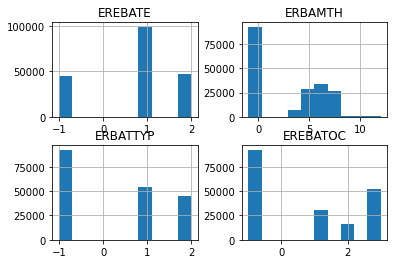

In [28]:
df[['EREBATE','ERBAMTH', 'ERBATTYP', 'EREBATOC']].hist()
df['ERBAMTH'].unique()

In [ ]:
# generate dummy for change in maritial status
spouse_sum = houshold.groupby(['pp'])['spouse'].sum()
houshold = houshold.merge(houshold.groupby(['pp'])['spouse'].sum(), on = 'pp', how = 'left' )
houshold['spouse'] = houshold['spouse_x']
houshold['spouse_sum'] = houshold['spouse_y']
houshold.drop('spouse_x', axis = 1, inplace = True)
houshold.drop('spouse_y', axis = 1, inplace = True)

#houshold[['spouse', 'spouse_sum']].describe()
#houshold['spouse_sum'].unique()

def get_change_spouse(spouse_sum):
    if spouse_sum == 0 or spouse_sum == 8 :
        return 0
    else:
        return 1
        
houshold['change_spouse'] = houshold.apply(lambda x: get_change_spouse(x['spouse_sum']),axis=1)

houshold[['change_spouse', 'spouse_sum']].describe()

## Open Questions

- leading zeros are gone since not string type?
- 75% instead of 81% rebated -> changes after grouping for HHs and subsetting?
- should I include famsize > 6 => famsize == 6?
- is there a difference between houshold and familysize? combine?



## ToDo
- topical modul joined only once per wave and needs to be in every row (change join or fill the other rows)
- subset on TAGE (18-65?) like Powell
- combine RHCALYR and RHCALMN as in the other notebook 
- redefine the dummy variables as 1, 0, np.NaN
- generate dummy for change in maritial status


- more data description grafically and in tabular form to select relevant variables.